**IMPORTANT:** Set the Colab GPU.

In [1]:
!pip3 install transformers --quiet

In [2]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



##Loading the corpus

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from google.colab import files
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

COLUNAS = ['noticia','classe']
df = pd.DataFrame(columns=COLUNAS)

path = '/content/drive/MyDrive/SatireRecognition/Corpus/SatiriCorpus (subcorpus)/reais'
data_reais = []

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r") as file:
            noticia = file.read()
            data_reais.append({'noticia': noticia, 'classe': 1})

path = '/content/drive/MyDrive/SatireRecognition/Corpus/SatiriCorpus (subcorpus)/satíricas'
data_satiricas = []

for filename in os.listdir(path):
    if filename.endswith(".txt"):
        with open(os.path.join(path, filename), "r") as file:
            noticia = file.read()
            data_satiricas.append({'noticia': noticia, 'classe': 0})

# Creating DataFrames for the data
df_reais = pd.DataFrame(data_reais)
df_satiricas = pd.DataFrame(data_satiricas)

# Concatenating DataFrames vertically
df = pd.concat([df_reais, df_satiricas], ignore_index=True)

Mounted at /content/drive


##Splitting the corpus into training and testing

In [4]:
from sklearn.model_selection import train_test_split

treinoteste, predicao = train_test_split(df, train_size=0.8, shuffle=True, random_state=1, stratify=df['classe'])

treino, teste = train_test_split(treinoteste, train_size=0.8, shuffle=True, random_state=1, stratify=treinoteste['classe'])

len(treino), len(teste), len(predicao)
pd.value_counts(treino['classe'])
pd.value_counts(teste['classe'])

pd.value_counts(treinoteste['classe'])
pd.value_counts(predicao['classe'])

0    30
1    30
Name: classe, dtype: int64

#Truncates the size of news in training

In [5]:
treino['noticia'] = treino['noticia'].str[:400]
teste['noticia'] = teste['noticia'].str[:400]

##Extracting the features and preparing the Training
As a feature, we will use the news text.

Using this information, the objective is to predict whether the news is real (1) or satirical (0).

In [6]:
def get_features(info):
  x = info['noticia']
  y = info['classe']
  #y = 0 if info["classe"] == 1 else 1
  return { 'X': x, 'y': y }

Importing dependencies.

For more information about these dependencies/libraries, see: https://github.com/neuralmind-ai/portuguese-bert

In [7]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report


Setting the parameters of the neural network.

**I'm not sure about any of these parameters**

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nclasses = 2
nepochs = 20
batch_size = 8
batch_status = 16
learning_rate = 1e-5
early_stop = 2

max_length = 128
write_path = 'model'
modelo = 'AlBERTina'    #  BERTimbau, RoBERTa, AlBERTina

Instanciando tokenizador, modelo, função de erro, otimizador e dados de treinamento e teste em lotes

**Também não tenho certeza de nada disso, só estou usando com base no código "original"**

In [9]:
# Set seed for reproducibility
import random
def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(20)

In [10]:
from torch.utils.data import DataLoader, Dataset

traindata = DataLoader([get_features(treino.iloc[i]) for i in range(len(treino))], batch_size=batch_size, shuffle=True)
testdata = DataLoader([get_features(teste.iloc[i]) for i in range(len(teste))], batch_size=batch_size, shuffle=True)


In [11]:
if modelo == 'BERTimbau':
  tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)
  model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased', num_labels=nclasses).to(device)
elif modelo == 'RoBERTa':
  tokenizer = AutoTokenizer.from_pretrained('verissimomanoel/RobertaTwitterBR', do_lower_case=False)
  model = AutoModelForSequenceClassification.from_pretrained('verissimomanoel/RobertaTwitterBR', num_labels=nclasses).to(device)
elif modelo == 'AlBERTina':    # https://huggingface.co/PORTULAN/albertina-ptbr
  tokenizer = AutoTokenizer.from_pretrained('PORTULAN/albertina-ptbr')
  model = AutoModelForSequenceClassification.from_pretrained('PORTULAN/albertina-ptbr', num_labels=nclasses).to(device)


optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at PORTULAN/albertina-ptbr and are newly initialized: ['classifier.weight', 'pooler.dense.weight', 'classifier.bias', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Definindo o método de avaliação

In [12]:
def evaluate(model, testdata):
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(testdata):
    texts, labels = inp['X'], inp['y']

    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs)

    pred_labels = torch.argmax(output.logits, 1)

    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())

    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)

  print(classification_report(y_real, y_pred, labels=[0, 1], target_names=['Satírica', 'Real']))
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  recall = recall_score(y_real, y_pred, average='weighted')
  prec = precision_score(y_real, y_pred, average='weighted')
  return f1, acc, recall, prec

## Training

**IMPORTANT:** Set the Colab GPU.

In [13]:
max_f1, repeat = 0, 0
for epoch in range(nepochs):
  model.train()
  f1, acc, recall, prec = evaluate(model, testdata)
  losses = []
  for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    # classifying
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    output = model(**inputs, labels=labels.to(device))

    # Calculate loss
    loss = output.loss
    losses.append(float(loss))

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(epoch, \
        batch_idx+1, len(traindata), 100. * batch_idx / len(traindata),
        float(loss), round(sum(losses) / len(losses), 5)))

  f1, acc, recall, prec = evaluate(model, testdata)

  print('F1: ', f1, 'Accuracy: ', acc, 'Recall: ', recall, 'Precision: ', prec)
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1

  if repeat == early_stop:
    break

              precision    recall  f1-score   support

    Satírica       0.50      0.96      0.66        24
        Real       0.50      0.04      0.08        24

    accuracy                           0.50        48
   macro avg       0.50      0.50      0.37        48
weighted avg       0.50      0.50      0.37        48

Train Epoch: 0 [16/24 (62%)]	Loss: 0.436579	Total Loss: 0.677410
              precision    recall  f1-score   support

    Satírica       0.96      1.00      0.98        24
        Real       1.00      0.96      0.98        24

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48

F1:  0.9791576204950064 Accuracy:  0.9791666666666666 Recall:  0.9791666666666666 Precision:  0.98
Saving best model...
              precision    recall  f1-score   support

    Satírica       0.96      1.00      0.98        24
        Real       1.00      0.96      0.98        2

## Prediction

Crivella diz que honestidade de Garotinho é tão real quanto Adão e Eva e Arca de Noé. 
O prefeito do Rio, Marcelo Crivella, disse que o ex-governador Garotinho “pode ter feito bobagem”, mas é “pobre e honesto e está sendo injustiçado por sofrer perseguição. 
O casal Garotinho foi preso ontem pela Polícia Federal sob acusação de financiamento ilegal de campanhas com a ajuda de um “braço armado”. 
Além disso, em entrevista ao Sensacionalista, o prefeito também afirmou que a honestidade de Garotinho é tão real e factual quanto a existência de Adão e Eva e a Arca de Noé. 
“Garotinho é honesto, tenho certeza que nunca roubou ninguém. 
O conheço há muito tempo, desde quando éramos jovens e ele sempre fazia papel de Barrabás nas peças da igreja”, disse Crivella. ; 0 ; 0
﻿Cachorro de Marcela se jogou no lago por ter que conviver com Temer. 
A primeira-dama Marcela Temer entrou de roupa e tudo há duas semanas em uma lagoa no Palácio da Alvorada, para resgatar seu cachorro Picolly. 
Segundo vete

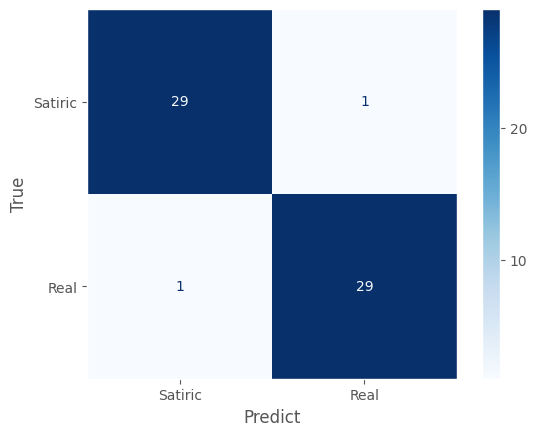

In [14]:
val_X = predicao['noticia'].values.tolist()
val_y = predicao['classe'].values.tolist()

ypredlista = []

ss = 0
rr = 0
rs = 0
sr = 0


for x, y in zip(val_X, val_y):

  inputs = tokenizer(x, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
  output = model(**inputs)

  pred_labels = torch.argmax(output.logits, 1)


  y_pred = pred_labels[0]

  ypred = y_pred.item()
  print(x,';',ypred,';',y)

  ypredlista.append(ypred)

  if ypred == 0:
    if y == 0: ss += 1
    if y == 1: sr += 1
  if ypred == 1:
    if y == 0: rs +=1
    if y == 1: rr +=1


print('{:0>2}'.format(ss), '|' , '{:0>2}'.format(rs))
print('{:0>2}'.format(sr), '|' , '{:0>2}'.format(rr))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(confusion_matrix(val_y, ypredlista))

print('------------------------------------')

target_names = ['Satiric', 'Real']


labels_names = [0,1]
print(classification_report(val_y, ypredlista,labels=labels_names, target_names=target_names, digits=4))
cm = confusion_matrix(val_y, ypredlista,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format=None)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acur = accuracy_score(val_y, ypredlista)
prec = precision_score(val_y, ypredlista, average='weighted')
cobe = recall_score(val_y, ypredlista, average='weighted')
medf = f1_score(val_y, ypredlista, average='weighted')

print('Accuracy: {:.4f}%'.format(acur))
print('Precision: {:.4f}%'.format(prec))
print('Recall: {:.4f}%'.format(cobe))
print('F-measure: {:.4f}%'.format(medf))

print('{:.4f}%'.format(acur) , '\t' , '{:.4f}%'.format(prec) , '\t' ,'{:.4f}%'.format(cobe) , '\t' ,'{:.4f}%'.format(medf))

plt.grid(False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.rcParams.update({'font.size': 26})
plt.show()